# COMS W4732 Homework 2: Machine Learning Basics

### GURSIFATH BHASIN (gb2760)
#### In collaboration with Chandan Suri (cs4090)

Following the machine learning content covered in class, in this assignment we will explore some crucial concepts in gradient descent and backpropgation. 

Specifically, in Section 1, we will work with a **feedforward neural network** (also known as a **multi-layer perceptron**) implemented solely in numpy, reflect on the associated details of the **forward** pass and implement the **backpropagation** parts of our layers to train our MLP. In Section 2, we will independently look at some gradient-based optimization techniques that are popular with convex functions and have been shown to be useful in finding sufficiently satisfactory optima on the loss manifolds on parametrized models. 

Your job is to implement the sections marked with `TODO` to complete the tasks. Your tasks on this homework will be:

## Section 1 (40 points) 
Review the details on the chain rule and the backproprapagation step from lecture. You should take a look at the guide we provide to get familiar with the forward pass and backward pass equations for a Multi-Layer Perceptron. You are required to implement all parts marked with a **TO DO:**. The goal of this assignment is to leave you with a very through understanding of forward pass as well as the backpropgation mechanics of a Multi-layer Peceptron. Namely, you will be working with:

* a **linear** layer with **Leaky ReLU** 
* a **linear** layer with a custom activation function that has a learnable parameter
* a **linear** output layer
* a **softmax cross-entropy** Loss layer 

## Section 2 (60 points). 
We will introduce different gradient-based iterative optimization techniques which came from the domain of convex optimization and which have since been adapted for loss functions of modern neural networks that have millions of parameters. Try out a few of these to appreciate the improvements they make on each other. Specifically, we will look at:
    
* **Full Gradient Descent**
* **Stochastic Gradient Descent**
* **Stochastic Gradient Descent + Momentum**
* **AdaGrad**
* **Adaptive Moment Estimation (ADAM)**

### About Submission

- Please submit the notebook (ipynb and pdf) including the output of all cells. Please note that you should export your completed notebook as a PDF (CV2_HW2_UNI.pdf) and upload it to GradeScope.
- Then, please submit the executable completed notebook (CV2_HW2_UNI.ipynb) to Cousework.
- For both files, 1) remember to replace <UNI> with your own uni; 2) the completed notebook should show your code, as well as the final image you created.

### Before your implementation

- Please check the packages listed in the **requirements.txt**. You can also use `pip install -r requirements.txt` to install the packages directly.
    

# Section 1: Backpropagation

This assignment is aimed at leaving you with a very solid understanding of how backpropogation works in the context of a Neural Network. We have provided most of the code for a MLP (Multi-layer Perceptron) written completely in Numpy with some functions left for you to implement to get the network up and running. 

On correct completion, you will be able to successfully train your MLP for any classification problem where the input feature vector is relatively low-dimensional. We've provided code that pre-processes and trains your MLP on the **Red Wine Classification** dataset for binary-classification. This is to enable you to quickly run and test your MLP. 

## Lets get to it!

As the building blocks of our MLP, we define three layer classes: Hidden, Output and Loss. 
Each of these inherit from our Base class and thus implement self.forward_pass(), self.backward_pass(), and contain self.update_weighhts(), which is already implemented. 

Before we dive in, we would like to highlight the distinction between the Hidden Layer and the Hidden_Vondrick layer as you will see defined below in the code.

### Hidden Layer
This is a standard Hidden Layer that uses Leaky ReLU as its activation function. Remember that Leaky ReLU is defined as a piecewise function:

$g(x)= \bigg\{
\begin{aligned}
& x:& x>0,&\\
& 0.01x:& x<=0 
\end{aligned}$

<br>

### Hidden_Vondrick Layer (utilizes cuztom activation function with learnable parameter)
This layer is similar to the standard Hidden layer, but with one notable exception. We will use a custom activation function g'(x). Furthermore, we will make exponent parameter 'n' learnable, and update it also leveraging the chain rule and backpropgation.

$g'(x)= \bigg\{
\begin{aligned}
& x^n:& x>0,&\\
& 0.01x:& x<=0 
\end{aligned}$

## Instructions

Go over the code for the MLP throughly and understand each update equation implemented as code. The forward_pass() method is implemented for you for every layer and thus you may find printing out variables and their shapes useful, before you begin implementing the backpropogation methods. Having a clear understanding of the forward and backward pass formulae is crucial for this Section. Your job is to implement only sections marked as **TO DO:** (7 in total)
(The PDF in the zip file is for your reference)

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Base:
    def __init__(self, input_dims:int, output_dims:int):
        self.input_dims = input_dims
        self.output_dims = output_dims

    def forward_pass(self):
        pass 
    
    def backward_pass(self):
        pass

    def update_weights(self, W, b, del_W, del_b, learning_rate):
        W-=(learning_rate*del_W)
        b-=(learning_rate*del_b)
        return W, b

class Hidden(Base):
    def __init__(self, input_dims:int, output_dims:int):
        super().__init__(input_dims, output_dims)
        
        self.W = np.random.random((input_dims, output_dims)) - 0.5
        self.c = np.random.random((1, output_dims)) - 0.5

    def forward_pass(self, X):
        U = X@ self.W + self.c
        activations= self.leaky_relu(U)
        return activations

    def backward_pass(self, X, h, dLdh, alpha, learning_rate):
        """
        TO DO:  Finish this backward_pass method by completing the lines marked by the #s. 
        Remember to use the helper functions update_weights(), leaky_relu, and leaky_relu_derivative wherever needed.
        """
        # this is dhdU
        relu_derivative = self.leaky_relu_derivative(h)
        dLdU = dLdh * relu_derivative
        dLdW = (X.T @ dLdU) + (alpha*self.W)
        dLdc = np.mean(dLdU, axis = 0)
        for_prev = dLdU @ (self.W.T)                                                              

        self.W, self.c = self.update_weights(self.W, self.c, dLdW, dLdc, learning_rate)
        return for_prev 
        """Note: for_prev is the gradient dL/dh' we pass onto the previous layer h' """ 

    def leaky_relu(self, inp):
        activation_mask = 1.0 * (inp >0) + 0.01*(inp<0)
        activations= np.multiply(inp, activation_mask)
        return activations 

    def leaky_relu_derivative(self, h):
        """
        TO DO: Implement the leaky_relu_derivative method. 
        This should return a numpy ndarray of shape (batch_size x self.output_dims)
        """
        leaky_relu_derivative = np.ones_like(h)
        shape = h.shape
        
        for i in range(shape[0]):
            for j in range(shape[1]):
                if h[i][j] <= 0:
                    leaky_relu_derivative[i][j] = 0.01
        return leaky_relu_derivative

class Hidden_Vondrick(Base):
    def __init__(self, input_dims:int, output_dims:int):
        super().__init__(input_dims, output_dims)
        
        self.W = np.random.random((input_dims, output_dims))
        self.c = np.random.random((1, output_dims))
        self.U= None
        self.vondrick_exponent= np.random.uniform(1.4,2) #The learnable exponent, called Vondrick Exponent, for our custom activation function is initilized from a Unifom(1.4,2) distribution. You may change this if you really want to, but keep it close to this range to ensure training stability.

        print("Intital Value of Vondrick Exponent: "+ str(self.vondrick_exponent) )

    def forward_pass(self, X):
        self.U =X@ self.W + self.c
        #Applys the custom activation elementwise
        activations= self.vondrick_activation(self.U)
        return activations

    def backward_pass(self, X, h, dLdh, alpha, learning_rate=0.0005):
    
        """
        # TO DO: Fill in this  backward pass method.
        """

        derivative_wrt_U, derivative_wrt_exponent = self.vondrick_activation_derivative()
        dLdU = dLdh * derivative_wrt_U
        dLdW = (X.T @ dLdU) + (alpha*self.W)
        dLdc = np.mean(dLdU, axis = 0)
        for_prev = dLdU @ (self.W.T)
        dL_dexponent_scalar = np.mean(dLdh * derivative_wrt_exponent)
 
        #Note, that for the purposes of training stablity, we have hard-coded the learning rate here to be 0.0005
        self.W, self.c = self.update_weights(self.W, self.c, dLdW, dLdc, 0.0005) 

        #Gradient Descent on our learnable activation function parameter: Updating exponent, but clipping it's lower range to 1.01
        self.vondrick_exponent= max(1.01,self.vondrick_exponent- 0.001*dL_dexponent_scalar )

        return for_prev

    def vondrick_activation(self, U):
        """
        TO DO:
        Implement this helper function that the forward pass uses compute to compute the activation map for the given input U.

        return activations: (batch_size x output_dims)
        """
        activation_mask = ((U**self.vondrick_exponent) * (U >0)) + 0.01*(U<0)
        activations= np.multiply(U, activation_mask)
        return activations 

    def vondrick_activation_derivative(self):
        """
        # TO DO:
        Implement this helper function that uses the stored self.U to do a backward pass and return both dh/dU and dh/dexponent. Both should be numpy matrices dimensions batch_size x self.output_dims 

        return activations: (batch_size x self.output_dims)
        """
        derivative_wrt_U = np.zeros_like(self.U)
        derivative_wrt_exponent = np.zeros_like(self.U)
        
        shape = self.U.shape
        for i in range(shape[0]):
            for j in range(shape[1]):
                if self.U[i][j] <= 0:
                    derivative_wrt_U[i][j] = 0.01
                    derivative_wrt_exponent[i][j] = 0
                else:
                    derivative_wrt_U[i][j] = self.vondrick_exponent*(self.U[i][j]**(self.vondrick_exponent - 1))
                    derivative_wrt_exponent[i][j] = (self.U[i][j] ** self.vondrick_exponent) * np.log(self.U[i][j])
                    
        return derivative_wrt_U, derivative_wrt_exponent

    
class Output(Base):

    def __init__(self, input_dims, output_dims):
        super().__init__(input_dims, output_dims)
        self.w = np.random.random((input_dims, output_dims)) -0.5
        self.b = np.random.random((1, output_dims)) -0.5

    def forward_pass(self, h):
        z = h @ self.w + self.b
        z = z - np.max(z, axis = 1).reshape(z.shape[0], 1) # trick: subtracting maz z as softmax is not effected: prevents overflow when we do exponentation
        return z

    def backward_pass(self, h, dLdz, alpha, learning_rate):
        """ 
        # TO DO: Implement the backward pass for the output layer. 
        Finally, update the Weight matrix and bias vector appropriately, and then return dLdh, which will be passed backed to previous layers during backpropgation
        """
        dLdw = (h.T @ dLdz) + (alpha*self.w)
        dLdb = dLdz[0] 
        dLdh = dLdz @ self.w.T 
      
        self.w, self.b = self.update_weights(self.w, self.b, dLdw, dLdb, learning_rate)
        return dLdh

class Loss(Base): 
    
    def __init__(self, input_dims, output_dims):
        super().__init__(input_dims, output_dims)
    
    def forward_pass(self, z, y):

        temp = -z + np.log(np.sum(np.exp(z), axis = 1)).reshape(z.shape[0], 1) #Computing Softmax Cross Entropy Loss terms for each z_i. Note dimensions of temp: batch_size x output layer output_dims
        L = temp[np.arange(z.shape[0]), y.flatten().astype(int)] #Extracts Loss term corresponding only to ground truth class from each row (sample). 
        L = np.mean(L) #Mean Loss over the batch
        return L 

    def backward_pass(self, z, y):
        #Recall the simplified expression we get for dL_i/dz_k= p_k- I(y_i=k) (Details in the guide)
        temp1 = np.zeros(z.shape)
        for i in range(z.shape[0]):
            true_class = int(y[i].item())
            temp1[i][true_class] = -1     #-1 is added to the loss term corresponding to the true class

        temp2 = np.exp(z)/ np.sum(np.exp(z), axis =1 ).reshape(z.shape[0], 1) #Matrik of p_k terms, aka, elements replaced by softmaxed probabilities
        for_previous = temp1 + temp2 
        return for_previous
    
class NN: 
    def __init__(self): 
        self.output_layer= self.loss_layer =  None 
        self.hidden_layers = []

    def add_layer(self, name, input_dims, output_dims):
        if name.lower() == 'hidden':
            self.hidden_layers.append(Hidden(input_dims, output_dims))
        elif name.lower() == 'hidden_vondrick':
            self.hidden_layers.append(Hidden_Vondrick(input_dims, output_dims))
        elif name.lower() =='output':
            self.output_layer = Output(input_dims, output_dims)
        elif name.lower() =='loss':
            self.loss_layer = Loss(input_dims, output_dims) 
    
    def forward_prop(self, X, y, alpha): 
        hidden_outputs = []
        z = L = h= None 
        for layer in self.hidden_layers:
            h = layer.forward_pass(X)
            hidden_outputs.append(h)
            X = h 
        z = self.output_layer.forward_pass(h)
        L = self.loss_layer.forward_pass(z, y)
        for layer in self.hidden_layers:
            L += 0.5*alpha*np.linalg.norm(layer.W)**2
        L+= 0.5*alpha* np.linalg.norm(self.output_layer.w)**2 
        return hidden_outputs, z, L 

    def backward_prop(self, X, hidden_outputs, z, y, alpha =0.01, learning_rate =0.01):
        dLdz = self.loss_layer.backward_pass(z, y)
        for_previous = self.output_layer.backward_pass(hidden_outputs[-1], dLdz, alpha, learning_rate) 
        for i in range(len(self.hidden_layers)-1,0,-1):
            temp = self.hidden_layers[i].backward_pass(hidden_outputs[i-1], hidden_outputs[i], for_previous, alpha, learning_rate)
            for_previous = temp 
        self.hidden_layers[0].backward_pass(X, hidden_outputs[0], for_previous, alpha, learning_rate)

    def train(self, X, y, epochs, batch_size, learning_rate, alpha, show_training_accuracy=True): 
  
        loss = []
        for epoch in range(epochs):
            predicted = self.predict(X)
            correct = 0 
            for i in range(len(predicted)):
                if predicted[i] == y[i]:
                    correct+=1
            if show_training_accuracy:
                print(f'the accuracy on the training data after epoch {epoch + 1} is {correct/X.shape[0]}')
            temp = total = 0 
            for k in range(0, X.shape[0], batch_size):
                inp = X[k:k+batch_size]
                out = y[k:k+batch_size]

                hidden_outputs, z, L = self.forward_prop(inp, out, alpha)
                temp+=L 
                total+=1
                self.backward_prop(inp, hidden_outputs, z, out, alpha, learning_rate)
            
            loss.append(temp/total)

        return loss

    def predict(self, X): 
        """
        TO DO:
        Implement the predict() method that takes in a batch input X (number_of_samples x feauture_vector_dims) and returns an nparray y of predictions (number_of_samples x 1)

        """
        hidden_outputs = []
        for layer in self.hidden_layers:
            h = layer.forward_pass(X)
            hidden_outputs.append(h)
            X = h 
        z = self.output_layer.forward_pass(h)
        predictions = [np.argmax(i) for i in z]
        return predictions
    
    def compute_accuracy(self, X, Y):
        predicted_Y= self.predict(X)
        correct=0
        for i in range(len(predicted_Y)):
            if predicted_Y[i] == Y[i]:
                correct+=1
        return correct/len(Y)

def plot_loss(loss_li):
    #Given a list of losses over the epochs, plots the loss curve.
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("loss of the neural network per epoch")
    plt.plot(loss_li)
    plt.show()

# Testing your MLP: Red Wine Quality Classification Dataset

## More about the dataset:
https://archive.ics.uci.edu/ml/datasets/wine+quality

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# If you are using colab, pls refer to commands below for file uploading. 
# Otherwise, just ignore it.
'''
from google.colab import files
uploaded = files.upload()
'''
wine_dataset = pd.read_csv('./winequality-red.csv')

In [5]:
#Converting Labels to a Binary Classification Problem
def Convert_Labels(data):
    data.loc[:,'quality'] = np.where(data.loc[:,'quality']>=6, 1, 0)
    return data

#Scales features to constrain them to lie within the default range (0,1)
def DataScaler(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    return data

all_columns = list(wine_dataset)
target = ['quality']
print(all_columns)
features = list(set(all_columns)-set(target))
print(features)
wine_dataset.loc[:,features] = DataScaler(wine_dataset.loc[:,features])

wine_dataset.head()

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
['total sulfur dioxide', 'density', 'volatile acidity', 'sulphates', 'citric acid', 'fixed acidity', 'chlorides', 'free sulfur dioxide', 'alcohol', 'pH', 'residual sugar']


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,5
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,5
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,5
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,6
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,5


In [6]:
label_converted_dataset = Convert_Labels(wine_dataset)
print(label_converted_dataset)
#As you can see, the quality column (our labels) now has either 0 (for quality<6) and 1 (for quality>=6)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.247788          0.397260         0.00        0.068493   0.106845   
1          0.283186          0.520548         0.00        0.116438   0.143573   
2          0.283186          0.438356         0.04        0.095890   0.133556   
3          0.584071          0.109589         0.56        0.068493   0.105175   
4          0.247788          0.397260         0.00        0.068493   0.106845   
...             ...               ...          ...             ...        ...   
1594       0.141593          0.328767         0.08        0.075342   0.130217   
1595       0.115044          0.294521         0.10        0.089041   0.083472   
1596       0.150442          0.267123         0.13        0.095890   0.106845   
1597       0.115044          0.359589         0.12        0.075342   0.105175   
1598       0.123894          0.130137         0.47        0.184932   0.091820   

      free sulfur dioxide  

In [7]:
#Quick Sanity check that our dataset it indeed relatively balanced
label_converted_dataset['quality'].mean()

0.5347091932457786

In [8]:
y_wine = label_converted_dataset.loc[:,'quality']
X_wine = label_converted_dataset.drop(target,axis=1)

In [9]:
X_wine_np= np.asarray(X_wine)
y_wine_np= np.asarray(y_wine)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine_np, y_wine_np, test_size=0.25, random_state=1)

Here, you compare your Neural Network's performance (Training and Test Accuracy) with that of Scikit-learn's built-in model MLPClassifier. We, of course, do not expect you to exceed their performance, but your accuracies should be reasonably close to MLPClassifier's.

For the Red Wine Dataset, you should be getting over 70% for both your training as well as test set accuracies. If your MLP's training accuracy hovers around 50%, that is a sign that your model is not learning and you need to go back and fix a bug in your implementation.

In [10]:
wine_quality_classifier = MLPClassifier(solver='sgd',
                                            alpha=0.01, 
                                            learning_rate_init=0.001,
                                            batch_size=16,
                                            hidden_layer_sizes=(12,8,2),
                                            random_state=1,
                                            max_iter=200
                                            )

wine_quality_classifier.fit(X_wine_train, y_wine_train)

MLPClassifier(alpha=0.01, batch_size=16, hidden_layer_sizes=(12, 8, 2),
              random_state=1, solver='sgd')

In [11]:
wine_quality_classifier.score(X_wine_test, y_wine_test)

0.75

## Evaluating your MLP on the Red Wine Dataset

First, we instantiate and train a standard MLP (that uses the RELU activation function).

In [12]:
my_wine_NN_1 = NN()
num_epochs= 150
lambda_reg= 0.01
learning_rate= 0.001
batch_size= 32

In [13]:
my_wine_NN_1.add_layer('Hidden', 11, 16) #Note that the first layer's weight matrix must be 11 x k , as the input feature vector is 11-dimensional.
my_wine_NN_1.add_layer('Hidden', 16, 12)
my_wine_NN_1.add_layer('Hidden', 12, 8)
my_wine_NN_1.add_layer('Output', 8, 2)
my_wine_NN_1.add_layer('Loss', 0, 0)

the accuracy on the training data after epoch 1 is 0.45454545454545453
the accuracy on the training data after epoch 2 is 0.47039199332777315
the accuracy on the training data after epoch 3 is 0.5045871559633027
the accuracy on the training data after epoch 4 is 0.5437864887406172
the accuracy on the training data after epoch 5 is 0.5404503753127606
the accuracy on the training data after epoch 6 is 0.5387823185988324
the accuracy on the training data after epoch 7 is 0.5387823185988324
the accuracy on the training data after epoch 8 is 0.5404503753127606
the accuracy on the training data after epoch 9 is 0.5454545454545454
the accuracy on the training data after epoch 10 is 0.5696413678065054
the accuracy on the training data after epoch 11 is 0.5804837364470392
the accuracy on the training data after epoch 12 is 0.6071726438698916
the accuracy on the training data after epoch 13 is 0.628023352793995
the accuracy on the training data after epoch 14 is 0.6655546288573811
the accuracy o

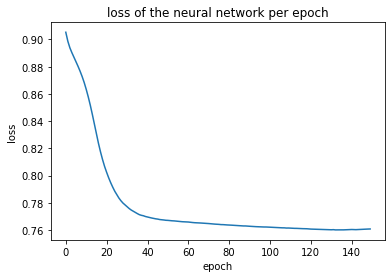

In [14]:
loss_wine_li_1= my_wine_NN_1.train(X_wine_train, y_wine_train, num_epochs, batch_size, learning_rate, lambda_reg)
plot_loss(loss_wine_li_1)

In [15]:
print(my_wine_NN_1.compute_accuracy(X_wine_test, y_wine_test))

0.76


In [16]:
my_wine_NN_2 = NN()
num_epochs= 100
lambda_reg= 0.01
learning_rate= 0.001
batch_size= 32

In [17]:
my_wine_NN_2.add_layer('Hidden', 11, 16) #Note that the first layer's weight matrix must be 11 x k , as the input feature vector is 11-dimensional.
my_wine_NN_2.add_layer('Hidden', 16, 12)
my_wine_NN_2.add_layer('Hidden_Vondrick', 12, 8)
my_wine_NN_2.add_layer('Output', 8, 2)
my_wine_NN_2.add_layer('Loss', 2, 2)

Intital Value of Vondrick Exponent: 1.88287696988187


the accuracy on the training data after epoch 1 is 0.46371976647206004
the accuracy on the training data after epoch 2 is 0.53628023352794
the accuracy on the training data after epoch 3 is 0.53628023352794
the accuracy on the training data after epoch 4 is 0.5404503753127606
the accuracy on the training data after epoch 5 is 0.5663052543786489
the accuracy on the training data after epoch 6 is 0.5963302752293578
the accuracy on the training data after epoch 7 is 0.6146788990825688
the accuracy on the training data after epoch 8 is 0.6355296080066722
the accuracy on the training data after epoch 9 is 0.6355296080066722
the accuracy on the training data after epoch 10 is 0.646371976647206
the accuracy on the training data after epoch 11 is 0.6663886572143453
the accuracy on the training data after epoch 12 is 0.6763969974979149
the accuracy on the training data after epoch 13 is 0.6905754795663053
the accuracy on the training data after epoch 14 is 0.69557964970809
the accuracy on the t

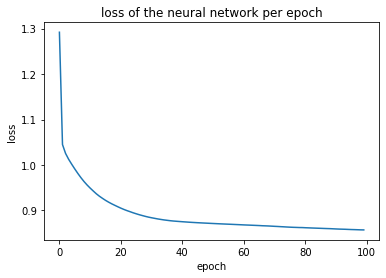

In [18]:
loss_wine_li_2= my_wine_NN_2.train(X_wine_train, y_wine_train, num_epochs, batch_size, learning_rate, lambda_reg)
plot_loss(loss_wine_li_2)

In [19]:
print(my_wine_NN_2.compute_accuracy(X_wine_test, y_wine_test))

0.7375


## Section 2: Optimization

You now have intuition for how the backpropagation procedure updates every single node or layer in the neural network with the gradient of the loss function with respect to the specific parameters. Luckily, you will not have to repeat this tedious enumeration in the future as autograd packages can help you track and organize the gradient tracking process. Even better, most modern neural network libraries like PyTorch and TensorFlow have their own autograd versions which abstract gradient calculations into a single function call on your loss function, instantly tracking along a computational neural network graph to quickly update gradients. 

Equally important to the machine learning pipeline is the process of optimization: actually using the calculated **gradient** at the current values and moving to the next values, which are closer to the optimal arguments to our function. A version of **stochastic gradient descent** was already used in section 1 to train the multilayer perceptron.

In a perfect world, once we have an analytical formulation for the gradient of a function, we can go back to the classic technique from Calc 2/Calc 3 of setting the gradient to 0 and calculating the values of the variables at the optimal location. Indeed take 

$$f(x, y) = x^2 + y^2$$

We have that:

$$\nabla f(x, y) = \begin{bmatrix}
2x \\
2y \\
\end{bmatrix} = \begin{bmatrix}
0 \\
0 \\
\end{bmatrix}$$

yielding the location of the optima at 

$$
\begin{bmatrix}
x \\
y \\
\end{bmatrix} = \begin{bmatrix}
0 \\
0 \\
\end{bmatrix}
$$

However, this technique does not work well with most functions: it is the exception rather than norm to set values to 0 to get and classify the optima. Moreover as the order of the partial derivatives increases, the resulting polynomials become harder and harder to solve (even if a solution is possible) and the problem quickly becomes computationally intractable. Second order methods (Hessian matrices) are required to further classify if these points are in any way useful (saddle points for example would be severely detrimental stopping points for our optimization problem) and are notoriously difficult computationally. 

We will now proceed to look at some well-known gradient-based iterative algorithms that have successfully been deployed in training deep learning models. In a typical machine learning pipeline, these optimizers will only be useful after the backpropagation stage is complete. At this stage we have that the network parameters $\theta$ have an associated gradient with respect to the loss $\frac{\delta\mathcal{L}}{\delta\theta}$. This step involves using the gradient to nudge $\theta$ towards an optimum value, i.e, the $\theta$ that would yield the lowest possible loss.

In reality, loss functions that are encountered in neural networks are parametrized by hundreds, thousands and millions of parameters, and hence it is not always easy to visualize or study the exact properties of optimization algorithms on them. Typically such optimization functions are designed for **convex** functions, which are characterized, amidst others by **Jensen's inequality**, meaning that the function always lies below any surface connecting two points on this surface, or precisely for a function $f: X \mapsto Y$:

$$ f(\theta \vec{x} + (1 - \theta)\vec{y}) \leq \theta \vec{x} + (1 - \theta)\vec{y}$$

for $x, y \in X$ and $0 \leq \theta \leq 1$. In $\mathbb{R}^3$ the **bowl** or **sphere** function is the archetypical convex function.

$$f(x, y) = x^2 + y^2$$

While convex theory gives convenient bounds on gradient based optimization, it is not enough to stop here as we do not expect the loss function for our machine learning models to be convex. Optimization research then focuses on studying the behavior of algorithms on test functions that accentuate some of the possible problematic optimization scenarios we might run into on a loss manifold in higher dimensions. For example, one potential issue we have studied in class is that in an iterative optimization process, we might get stuck in a local optima. A potential test function that could especially be indicative of if an optimization algorithm handles this issue, is the following function, which we will call the **mult** function:

$$f(x, y) = \sin(\sqrt(x^2 + y^2)) $$

Another issue could be a point which has different signs to its curvature in different directions, but locally has no gradient, aka a saddle point. A "test" function to effectively evaluate an algorithm's performance on saddle points could be 

$$f(x, y) = x^3 + 3x y^2$$

or otherwise known as the **monkey saddle**. 

As a final example, it might be concerning if a point has a very high gradient in one direction but extremely low gradient aka a high condition number is associated with its eigendecomposition of the Hessian (if you didn't understand this last line, that's fine- the Hessian only comes into play while giving a proof of convergence for convex functions for gradient descent and such theory is beyond the scope of this class. An alternate way of thinking why this is an issue is because it will cause a zig-zag convergence to the optima when we can potentially save a lot of iterations by just taking a step along one axis). A function to test convergence performance emperically for this issue could be one shaped like a taco shell. A well known function of this kind is the **Matyas** function.

$$f(x, y) = 0.26(x^2 + y^2) -0.48xy$$

Bonus point for figuring out who the **Matyas** function is named after, because I looked forever in the hopes of adding a half-clever note on who Matyas was to improve the readability of this homework with a casual fun fact that has nothing to do with machine learning, but I ended up getting lost online and achieving nothing for 30 mins.

**Implement the said functions below as bowl, mult, monkey and matyas and use the plot function below to visualize what they look like. Add a comment on each to explain what there utility might be as test functions.**

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import matplotlib.colors
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial


def bowl():
    '''
    TODO

    Implement the bowl function as defined above.

    Add comment here explaining why it is a reasonable test function.
    
    The bowl function is a convex function which means it must always converge. 
    It is a reasonable test function since it can be used to check whether an optimzation algorithm 
    converges to the global optima or not.
    '''

    def f_bowl(x, y):
        
        out = np.square(x) + np.square(y)
    
        return out
    
    def opt_bowl():
        
        return np.array([0., 0.])
    return f_bowl, opt_bowl

    
    
def mult():
    '''
    TODO

    Implement the mult function as defined above.

    Add comment here explaining why it is a reasonable test function.
    
    The mult function can be used to test whether an optimization algorithm gets stuck on a local optima. 
    So, it can be used as a test function.
    '''
    
    def f_mult(x, y):
        f_bowl, opt_bowl = bowl()
        out = np.sin(np.sqrt(f_bowl(x, y)))
        
        return out
    
    def opt_mult():
        
        return np.array([0., 0.])
    
    return f_mult, opt_mult

def monkey():
    '''
    TODO

    Implement the monkey saddle function as defined above.
    Add comment here explaining why it is a reasonable test function.
    
    This function can be used to test whether an optimization algorithm is able to converge to the global
    optima in the presence of a saddle point, i.e., a point which has different signs to its curvature in 
    different directions, but has no gradient locally.
    '''

    def f_monkey(x, y):

        out = np.power(x, 3) + 3*np.multiply(x, np.power(y, 2))
        
        return out
    
    def opt_monkey():
        
        return np.array([0., 0.])
    
    return f_monkey, opt_monkey

    
def matyas():
    '''
    TODO

    Implement the mult function as defined above.

    Add comment here explaining why it is a reasonable test function.
    
    This function can be used to test how an optimzation algorithm works on point that has a very high gradient 
    in one direction but extremely low gradient in another.
    '''

    def f_matyas(x, y):

        f_bowl, opt_bowl = bowl()
        out = 0.26*f_bowl(x, y) - 0.48*np.multiply(x, y)
        
        return out
    
    def opt_matyas():
        
        return np.array([0., 0.])
        
    
    return f_matyas, opt_matyas


def plot_func(f):
    
    func, opt = f()
    
    #Set grid parameters
    xmin = -4.5
    xmax= 4.5
    ymin = -4.5
    ymax = 4.5
    step = 0.2
    
    x, y = np.meshgrid(np.arange(xmin, xmax + step, step), np.arange(ymin, ymax + step, step))
    z = func(x, y)
    cp = opt()
    optima = cp.reshape(-1, 1)
    
    fig = plt.figure(figsize=(12,6), dpi = 100)
    ax = fig.add_subplot(1,2,1,projection='3d')
    ax.plot_surface(x, y, z,  rstride=5, cstride=5, alpha = 0.5, cmap=plt.cm.plasma)
    cset = ax.contourf(x, y, z, 25, zdir='z', offset=-1, alpha=0.6, cmap=plt.cm.coolwarm)
    out1 = func(*optima)
    
    ax.plot(*optima, out1 , 'r*', markersize=10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

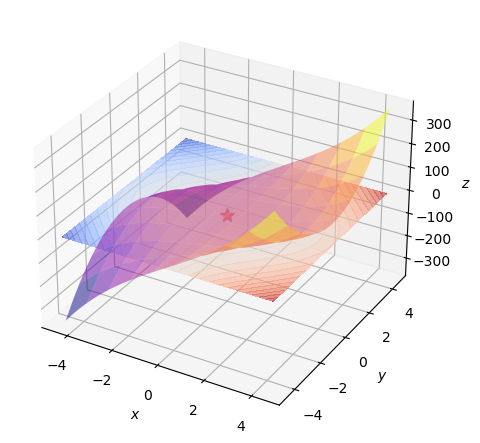

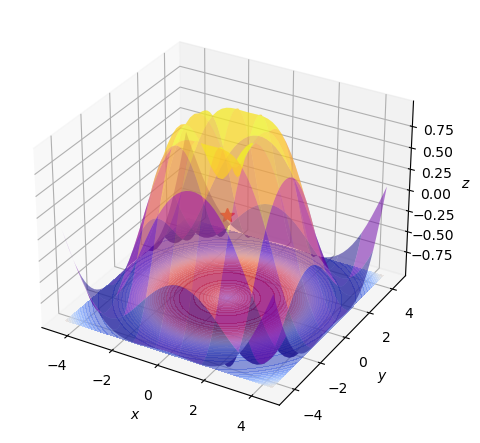

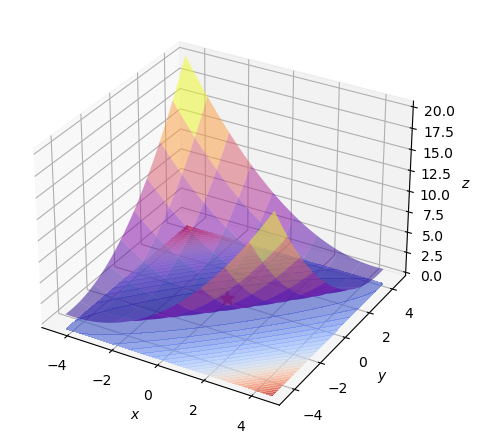

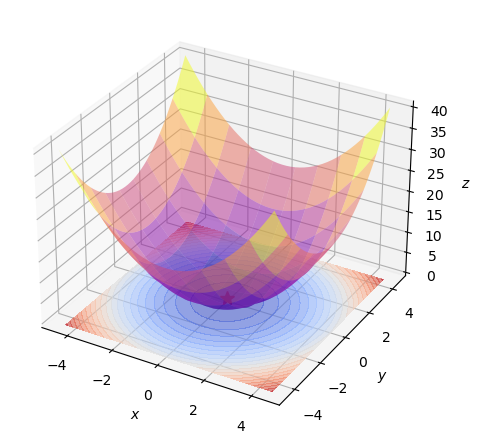

In [21]:
plot_func(monkey)
plot_func(mult)
plot_func(matyas)
plot_func(bowl)

## Gradient Descent 

$$ \theta = \theta - \alpha \nabla_{\theta}\mathcal{L}(\theta)$$

We computed the gradient with respect to each of the parameters and make an update in the opposite direction of the local gradient. $\alpha$ which is the learning rate, is a hyperparam that controls how quickly gradient descent converges. If it is too low, too many updates may be required, especially as gradients are small, and if it is too large you may overshoot the optima. In the context of batch gradient descent- at each epoch where the above update is ran- batch gradient descent requires that the entire loss function be computed at each stage through a pass through the entire training data so that the calculation of the $\mathcal{L}(\theta)$ and its subsequent gradient be accurate. As a result, this method is usually very slow. Additionally, it is only guaranteed to converge to the global minimum for convex functions such as the bowl functions and this is often not the case in machine learning, in which case it is guaranteed to only converge to local minima.

Implement a version of gradient descent below.

In [22]:
def gradient_descent(x, y, dx, dy, hparams):
    '''
    x: value of x before update
    y: value of y before update
    dx: derivative wrt x
    dy: derivative wrt y
    hparams must contain alpha

    TODO

    Implement the update rule and return the new value of x, y after the update
    '''
    
    alpha = hparams['alpha']
    x = x - alpha*dx
    y = y - alpha*dy
    
    return x, y 

## Stochastic Gradient Descent

$$ \theta = \theta - \alpha \nabla_{\theta}\mathcal{L}(\theta; x^i, y^i)$$

This method is very similar to full gradient descent, except that instead of calculating the loss function over all training examples, the loss function is only calculated over a single training data point at a time. As such the estimate of $\mathcal{L}(\theta)$ and its gradient is not precise, but in return, SGD is much faster, and additionally reduces redundant time for recomputing gradients for similar examples.

Gradients received can be highly erratic because they are not calculated over the full dataset, and as a result the optimization path will often zig zag and occasionally spiral out of control. It has been shown that with enough control over the learning rate, sgd and batch gradient descent often achieve the same results, but SGD does it much faster in the context of machine learning. A commonly used variant of gradient descent that sits between full and stochastic gradient descent is mini-batch gradient descent where the gradient and loss function are calculated over a randomly chosen fixed size batch of training examples.

Implement a version of stochastic gradient descent below. Since we are not actually using a dataset or even a data distribution to generate our "loss" manifold that we are trying to optimize over, you should simulate the effect of approximation using gaussian noise on the gradients. Feel free to use the gauss function imported below for the same.

In [23]:
from random import gauss

def stochastic_gradient_descent(x, y, dx, dy, hparams):
    '''
    x: value of x before update
    y: value of y before update
    dx: derivative wrt x
    dy: derivative wrt y
    hparams must contain alpha

    # TODO

    Implement the update rule and return the new value of x, y after the update
    '''
    
    alpha = hparams['alpha']
    
    x = x - alpha*(dx + gauss(0, np.sqrt(4.5)))
    y = y - alpha*(dy + gauss(0, np.sqrt(4.5)))
    
    return x, y

## Stochastic Gradient Descent and Momentum

$$ \nu_t = \gamma\nu_{t-1} + \alpha \nabla_{\theta}\mathcal{L}(\theta; x^i, y^i) $$
$$ \theta = \theta - \nu_t $$

Stochastic Gradient Descent suffers very heavily if the loss function changes very quickly in one direction and slowly in another direction (eg. taco shell function) In this case the direction of the gradient does not align with the direction toward the minimum and a zig zag motion is direction with slower gradients. This is the case where the Hessian of the loss function wrt parameters has a high condition number, aka the eigenvalues of the representative matrix have a high ratio between the highest and the lowest eigenvalue. 

The use of the word momentum is a metaphor in this context, as such a method allows the navigation of shallow local optima or the navigation of ravines using the build-up of gradients from the navigation. The idea is that we maintain what is a 'velocity' term $\nu$ at each timestep that keeps track of how much gradient has so far been encountered. Hence this value builds up in each direction and even in cases when gradients received in training are poor (eg. around saddle points, or local minima), the algorithm is able to escape such points (much like a ball rolling down a hill). The term for gamma, which is a hyperparameter, can be thought of as friction for the build-up of this velocity, as it decides how much of the previous velocity to count at a certain timestep. Even in the case of a ravine, the zig-zag motion of stochastic gradient descent would reduce as the buildup term in one direction would carry us smoothly through the low-gradient sensitive dimension. The momentum vectors also help cancel/smooth some of the noise that results from approximating gradients using a single data point, aka, the stochastic way.

This method has its own flaws: it might settle in extremely deep minima. Such minima are not desirable even as global minima, as on a data manifold they may be "too good" to be true; representative of a kind of overfit. An example test function for this issue is the **Easom function**. The good news is that with some tuning of **gamma** more often that never SGD + momentum will settle in shallow, wide minima.

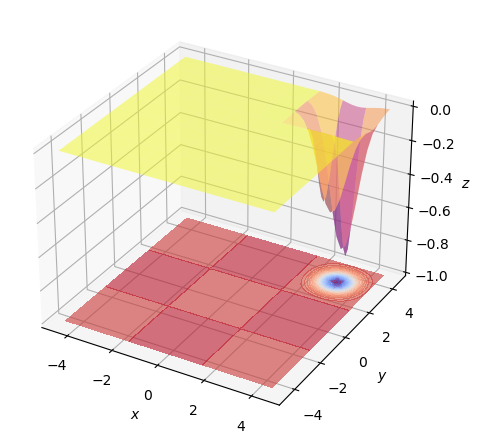

In [24]:
def easom():
    '''
    TODO

    Implement the easom function as defined above.

    Add comment here explaining why it is a reasonable test function.
    '''
    
    def f_easom(x, y):
        
        out = -np.cos(x)*np.cos(y)*np.exp(-np.square((x-np.pi)) - np.square(y-np.pi))
        return out
        
    def opt_easom():
        
        return np.array([np.pi, np.pi])
    
    
    return f_easom, opt_easom
        
plot_func(easom)

Implement your version of stochastic gradient descent with momentum below.

In [25]:
def momentum(x, y, dx, dy, v_x, v_y, hparams):
    '''
    x: value of x before update
    y: value of y before update
    dx: derivative wrt x
    dy: derivative wrt y
    v_x: velocity parameter wrt x
    v_y: velocity parameter wrt y
    hparams must contain alpha and gamma

    # TODO

    Implement the update rule and return the new value of x, y, v_x, v_y after 
    the update. Don't forget to add the gaussian noise for the stochasticity
    '''
    
    alpha = hparams['alpha']
    gamma = hparams['gamma']
    
    dx += gauss(0, 1)
    dy += gauss(0, 1) 
    
    v_x = np.multiply(gamma, v_x) + alpha*dx
    x = x - v_x
    v_y = np.multiply(gamma, v_y) + alpha*dy
    y = y - v_y
    
    return x, y, v_x, v_y

## Nesterov Momentum

$$ \nu_t = \gamma\nu_{t-1} + \alpha \nabla_{\theta}\mathcal{L}(\theta - \gamma\nu_{t-1}) $$
$$ \theta = \theta - \nu_t $$

A problem with momentum is that there is no way to control the slow-down of the optimizer even as we approach a minima- the optimizer isn't smart enough to decide whether or not it needs to continue up a slope once it has reached a (local or global) minima. A version of momentum, called Nesterov momentum helps deal with this problem by first changing parameters in the direction of the accumulated gradient, estimating the destination gradient and then making an update in that direction.

You do not have to implement nesterov updates.

## AdaGrad

Adagrad is another approach toward solving some of the same problems that momentum attempts to solve. However, it does more by giving the optimizer the ability to adapt updates for individual parameters depending on their importance. It adapts its learning rate to make higher updates (higher learning rate) for dimensions/features with higher values and lower updates (low learning rate) for dimensions/features with lower values.

$$ G_{i, i}^{t+1} = G_{i, i}^{t} + (\frac{\delta\mathcal{L}(\theta)}{\delta\theta_i})^2 $$
$$ \theta_{t,i} = \theta_{t-1, i} - \frac{\alpha}{\sqrt{G_{i,i} + \epsilon}}\nabla_{\theta}\mathcal{L}(\theta_{t, i}) $$

Here $G$ starts off as a 0 matrix and builds up squared gradients for each feature/dimension which is later used to scale the value for the parameter updates. $\epsilon$ is generally a very small number to ensure that division by zero does not occur in case the initialization point provides no gradient. The biggest advantage of adagrad is that it takes away the need to manually tune the learning rate as is required with SGD, and provides feature-tuned learning rates. However, because of the way adagrad adjusts learning rates it sometimes tends to work well only with convex problems, as with non-convex problems in runs into issues with how to overshooting local minima/saddle points as it slows down rapidly due to accumulating squared gradients. It also provides really slow initial updates if the gradients at the initialization point are really high.

Implement your variant of Adagrad below.



In [26]:
def adagrad(x, y, dx, dy, v_x, v_y, hparams):
    '''
    x: value of x before update
    y: value of y before update
    dx: derivative wrt x
    dy: derivative wrt y
    v_x: velocity parameter wrt x
    v_y: velocity parameter wrt y
    hparams must contain eps and alpha

    # TODO

    Implement the update rule and return the new value of x, y, v_x, v_y after 
    the update. Don't forget to add the gaussian noise for the stochasticity.
    '''
    
    eps = hparams['eps']
    alpha = hparams['alpha']
    
    dx += gauss(0, 1)
    dy += gauss(0, 1)
    
    v_x = v_x + np.square(dx)
    x = x - ((alpha / (np.sqrt(v_x + eps)))*dx)
    
    v_y = v_y + np.square(dy)
    y = y - ((alpha / (np.sqrt(v_y + eps)))*dy)
    
    return x, y, v_x, v_y

**RMSProp** and **AdaDelta** are two different algorithms that combat the aggressive learning rate reduction that comes with AdaGrad.

## Adaptive Momentum Estimation

This is the **best of all worlds** update algorithm. The second line (f) accumulated gradients much like momentum, while the third line (s) accumulates gradient squared for adjusting the learning rates like AdaGrad. These have to be adjusted in lines 3 and 4, because they are initialized to 0 at the beginning of optimization and since f is in the numerator of the final update we cannot afford to multiply by a really small number, neither can we afford to divide by a really small number. $\beta_1$ and $\beta_2$ must be less than 1 and are typically initialized high values such as 0.9 or 0.99. Yhe unbiasing operations on line 4 and 5 above help bring up the values of f and s early in training. 
    

$$ g_{t, i} = \nabla_{\theta}\mathcal{L}(\theta_{t, i}) $$
$$ f_{t, i} = \beta_1 f_{t-1, i} + (1-\beta_1) g_{t, i} $$ 

$$ s_{t, i} = \beta_2 s_{t-1, i} + (1-\beta_2) g_{t, i}^2 $$
$$ \hat{f_{t, i}} = \frac{f_{t, i}}{1 - \beta_1^t}$$
$$ \hat{s_{t, i}} = \frac{s_{t, i}}{1 - \beta_2^t}$$
$$ \theta_{t+1,i} = \theta_{t, i} - \frac{\alpha\hat{f_{t, i}}}{\sqrt{\hat{s_{t, i}} + \epsilon}}$$

Implement your function for adam below. Follow the comments closely for interpretation of inputs and outputs.

In [43]:
def adam(x, y, dx, dy, f_x, f_y, s_x, s_y, i, hparams):
    '''
    x: value of x before update
    y: value of y before update
    dx: derivative wrt x
    dy: derivative wrt y
    f_x, f_y: first order gradient accumulators
    s_x, s_y: second order gradient accumulators
    i: number of iteration
    hparams must contain alpha, eps, beta_1 and beta_2

    # TODO

    Implement the update rule and return the new value of x, y, f_x, f_y, s_x, 
    s_y, after the update. Don't forget to add the gaussian noise for 
    the stochasticity.
    '''
    i += 1
    eps = hparams['eps']
    alpha = hparams['alpha']
    beta_1 = hparams['beta_1']
    beta_2 = hparams['beta_2']
    
    dx += gauss(0, 1)
    dy += gauss(0, 1)
    
    f_x = beta_1*f_x + (1 - beta_1)*dx
    s_x = beta_2*s_x + (1 - beta_2)*np.square(dx)
    f_x_hat = f_x / (1 - np.power(beta_1, i))
    s_x_hat = s_x / (1 - np.power(beta_2, i))
    x = x - ((alpha*f_x_hat) / (np.sqrt(s_x_hat + eps)))
    
    f_y = beta_1*f_y + (1 - beta_1)*dy
    s_y = beta_2*s_y + (1 - beta_2)*np.square(dy)
    f_y_hat = f_y / (1 - np.power(beta_1, i))
    s_y_hat = s_y / (1 - np.power(beta_2, i))
    y = y - ((alpha*f_y_hat) / (np.sqrt(s_y_hat + eps)))
    
    return x, y, f_x, f_y, s_x, s_y    

Study in detail the class Optimizer that has been implemented below, because you will be using it to study the effect of key hyperparameters on the optimization process, and the difference that the bells and whistles on Gradient Descent can make. The **fit** function calls the methods you have implemented above depending on how you initialize the class.

In [28]:
from random import seed
import math

seed(1)

class Optimizer:
    
    def __init__(self, x_init, y_init, method, func, hparams):
        
        '''
        x_init: Initialization x point
        y_init: Initialization y point
        method: adam, adagrad, sgrad, ... check the fit function below
        func: function to optimize [mult, easom, monkey, bowl, matyas, ...]
        hparams: alpha, gamma, eps, beta, beta_1, beta_2
        '''
        
        f, optima = func()
        
        self.x = x_init
        self.y = y_init
        self.hparams = hparams
        self.first = True
        self.iter = 0
        self.x_list = []
        self.y_list = []
        
        cp = optima()
        self.cp_x = np.asscalar(np.array([0]))
        self.cp_y = np.asscalar(np.array([1]))
        
        self.method = method
        self.f = f
        self.f_gradx = grad(f, 0)
        self.f_grady = grad(f, 1)
        self.count = 0
        
    def distance(self, x, y):
        '''
        L2 Norm
        '''
        
        return math.sqrt((x-self.cp_x)**2 + (y-self.cp_y)**2)
        
    def cgrad(self, x, y):
        '''
        Uses autograd
        '''
        
        return self.f_gradx(x, y), self.f_grady(x, y)
        
    def fit(self, epochs):

        '''
        Epochs: max number of updates to be made
        '''

        
        self.x_list = []
        self.y_list = []
        self.z_list = []
        
        if self.method == 'grad':
            
            '''
            USES
            alpha: learning rate'
            '''
            
            for i in range(epochs):
                
                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y = gradient_descent(self.x, self.y, dx, dy, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
                    
                
        if self.method == 'sgrad':
            
            '''
            USES
            alpha: learning rate
            '''
            
            for i in range(epochs):

                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y = stochastic_gradient_descent(self.x, self.y, dx, dy, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
        
                
                
        if self.method == 'grad_momentum':
            
            '''
            USES
            alpha: learning rate
            gamma: momentum factor
            '''
            
            v_x, v_y = 0., 0.
            for i in range(epochs):
                
                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y, v_x, v_y = momentum(self.x, self.y, dx, dy, v_x, v_y, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
                
        if self.method == 'adagrad':
            
            '''
            USES
            alpha: learning rate
            eps: 
            '''
            
            v_x, v_y = 0., 0.
            for i in range(epochs):
                
                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y, v_x, v_y = adagrad(self.x, self.y, dx, dy, v_x, v_y, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
                    
                
        if self.method == 'adam':
            
            '''
            USES
            alpha: learning rate
            beta_1:
            beta_2:
            eps: 
            '''
            
            f_x, f_y = 0., 0.
            s_x, s_y = 0., 0.
            for i in range(epochs):

                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y, f_x, f_y, s_x, s_y = adam(self.x, self.y, dx, dy, f_x, f_y, s_x, s_y, i, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
          

The code at the bottom provides helper functions to help you visualize your results and play around with your optimizer implementations.

In [29]:
def animate(i):
    '''Plotting helper'''
    
    i = int(i*(epochs/frames))
    line1.set_data(optim.x_list[:i+1], optim.y_list[:i+1])
    line1.set_3d_properties(optim.z_list[:i+1])
    line2.set_data(optim.x_list[:i+1], optim.y_list[:i+1])
    line2.set_3d_properties(np.zeros(i+1) -1)
    title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, optim.z_list[i]))
    
    return line1, line2, title


def plot_function(epochs, frames, func, xmin = -4.5, xmax= 4.5, ymin = -4.5, ymax = 4.5, step = 0.2, option = '3d'):

    '''
    Plot the optimization
    epochs: number of optimization improvements
    frames: number of displayed frames
    func: function to plot. eg. mult, monkey, ....
    xmin: Min value of x to be displayed
    xmax: Max value of x to be displayed
    ymin: Min value of y to be displayed
    ymax: Max value of y to be displayed
    step: Split between xmin and xmax, ymin and ymax
    option: keep this option '3d'

    '''    

    x, y = np.meshgrid(np.arange(xmin, xmax + step, step), np.arange(ymin, ymax + step, step))
    f, opt = func()
    z = f(x, y)
    cp = opt()
    
    optima = cp.reshape(-1, 1)
    
    if (option == '3d'):
        
        fig = plt.figure(figsize=(12,6), dpi = 100)
        ax = fig.add_subplot(1,2,1,projection='3d')

        ax.plot_surface(x, y, z,  rstride=5, cstride=5, alpha = 0.5, cmap=plt.cm.plasma)
        cset = ax.contourf(x, y, z, 25, zdir='z', offset=-1, alpha=0.6, cmap=plt.cm.coolwarm)
        out1 = f(*optima)
        ax.plot(*optima, out1 , 'r*', markersize=10)

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')
        
        
        i = 0

        for i in range(epochs):
            line1, = ax.plot(optim.x_list[:i+1], optim.y_list[:i+1], optim.z_list[:i+1], color ='black', marker = '.')

            line2, = ax.plot(optim.x_list[:i+1], optim.y_list[:i+1], np.zeros(i+1)-1, color ='red', marker='.')
            
    
    if (option == '2d'):
        
        fig = plt.figure(dpi = 100)
        ax = plt.subplot(111)
        
        cset = ax.contourf(x, y, z, 25, zdir='z', offset=-1, alpha=0.6, cmap=plt.cm.bwr)
        
        dz_dx = egrad(f, argnum=0)(x, y)
        dz_dy = egrad(f, argnum=1)(x, y)
        ax.quiver(x, y, x- dz_dx, y-dz_dy, alpha = 0.5)
        ax.plot(*optima, 'r*', markersize = 18)

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')


    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show

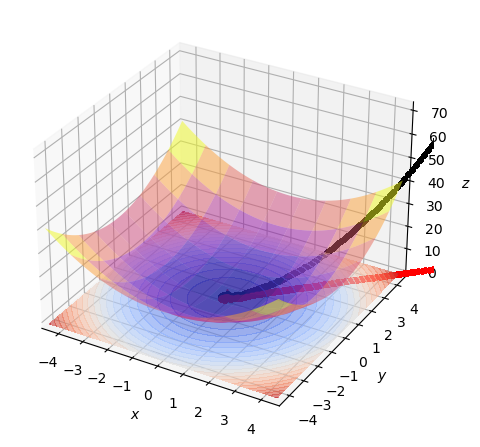

In [30]:
'''
Test plot: Here, we plot optimization with adam on bowl function for 200 updates,
initialized at (6., 6.).
'''

frames = 20
epochs = 200

func = bowl
init_x, init_y = 6., 6.

hparams = {'alpha': 0.1, 'eps': 1e-7, 'beta_1': 0.8, 'beta_2': 0.99}
optim = Optimizer(init_x, init_y, 'adam', func, hparams)
optim.fit(epochs)

plot_function(epochs, frames, func)

# Importance of learning rate

Call the plotting function and Optimizer as shown above and make two plots to show how too high or too low of a learning rate could be a problem for stochastic gradient descent on the bowl function. Keep the number of iterations (epochs) constant across the two to demonstrate the effect. You are recommended to use the bowl function.


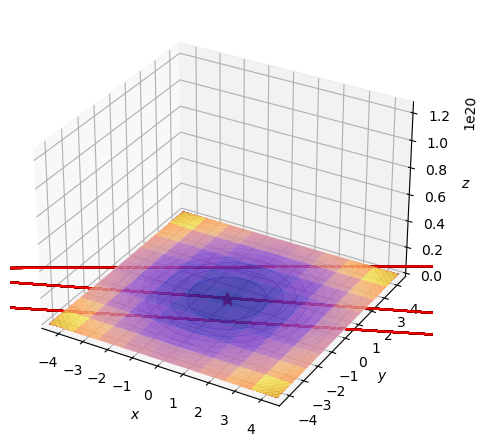

In [31]:
frames = 20
epochs = 20

'''
TODO

Make a plot to show what happens if the learning rate is too high with sgrad.

Recommended hparams:

initialization: (6., 6.)
alpha: 2
'''

func = bowl
init_x, init_y = 6., 6.

hparams = {'alpha': 2}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

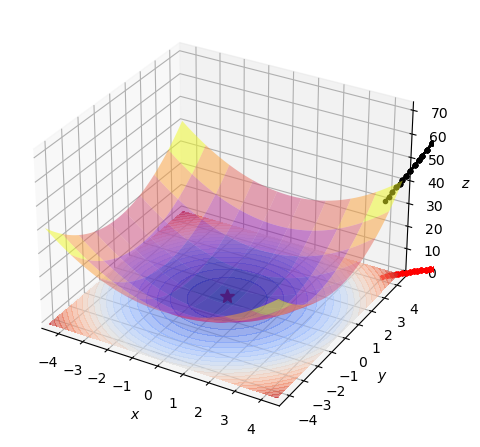

In [32]:
frames = 20
epochs = 20

'''
TODO

Make a plot to show what happens if the learning rate is too low with sgrad.

Recommended hparams:

initialization: (6., 6.)
alpha: 0.01
'''

func = bowl
init_x, init_y = 6., 6.

hparams = {'alpha': 0.01}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

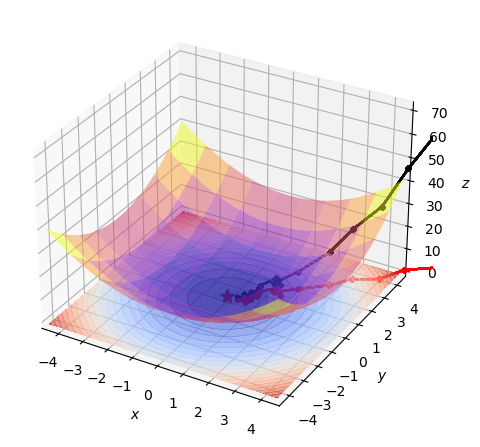

In [33]:
'''
TODO

Make a plot to show what happens if the learning rate is just right with sgrad.

Recommended hparams:

initialization: (6., 6.)
alpha: 0.1
'''

frames = 20
epochs = 20

func = bowl
init_x, init_y = 6., 6.

hparams = {'alpha': 0.1}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

# SGD and Matyas: momentum helps

Make two plots to show how momentum possibly helps with navigating a taco-shell function like Matyas, where gradient is low in one direction and high in another direction. Keep all parameters except the type of optimizer constant. 

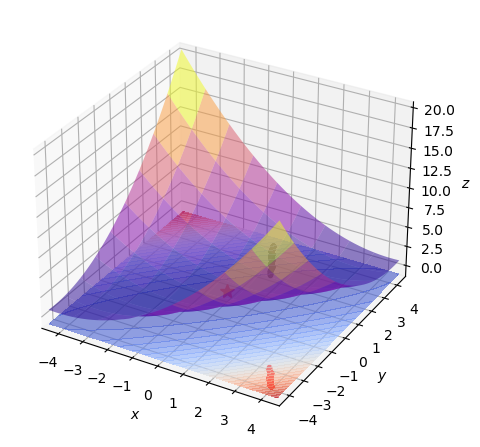

In [34]:
frames = 20
epochs = 20

'''
TODO

Make a plot to show what happens if stochastic gradient descent is used on a 
function like this.

Recommended hparams:

initialization: (4., -4.)
alpha: 0.01
'''

func = matyas
init_x, init_y = 4., -4.

hparams = {'alpha': 0.01}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

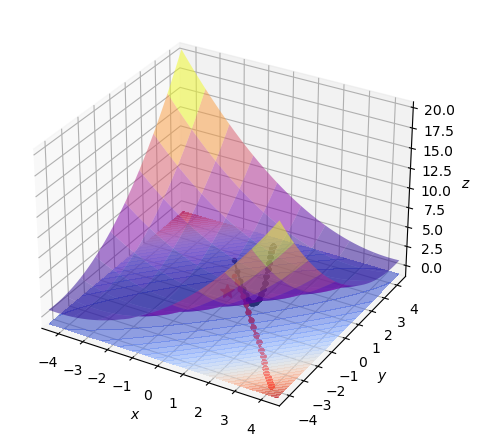

In [35]:
frames = 20
epochs = 20

'''
TODO

Make a plot to show what happens if stochastic gradient descent with momentum
is used on a function like this.

Recommended hparams:

initialization: (4., -4.)
alpha: 0.01
gamma: 0.99
'''

func = matyas
init_x, init_y = 4., -4.

hparams = {'alpha': 0.01, 'gamma': 0.99}
optim = Optimizer(init_x, init_y, 'grad_momentum', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

# Exploring Saddle Points

Make three plots to show how SGD, momentum, and adagrad behave on the monkey function. A good optimization algorithm will move past the flat region and continue its trajectory downward. Do not change the learning rate as this has been artificially reduced to make the distinction clear on this problem. Do you notice the observations made in the text above?

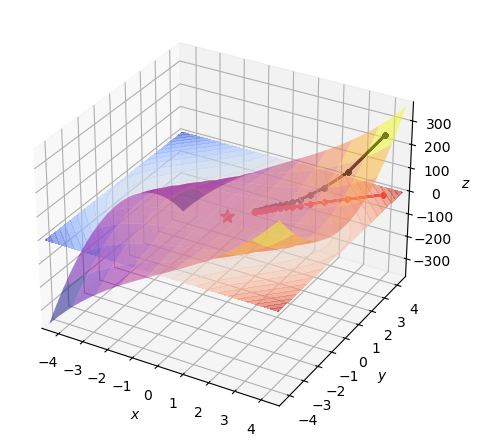

In [36]:
frames = 20
epochs = 20

'''
TODO

Make a plot to show what happens if stochastic gradient descent is used on a 
function like this.

Recommended hparams:

initialization: (4., 4.)
alpha: 0.01
'''

func = monkey
init_x, init_y = 4., 4.

hparams = {'alpha': 0.01}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

We observe that despite running the optimizer for 20 epochs, Stochastic Gradient Descent is not able to move past the flat region. Thus, it is not a good optimization algorithm according to the aforementioned definition.

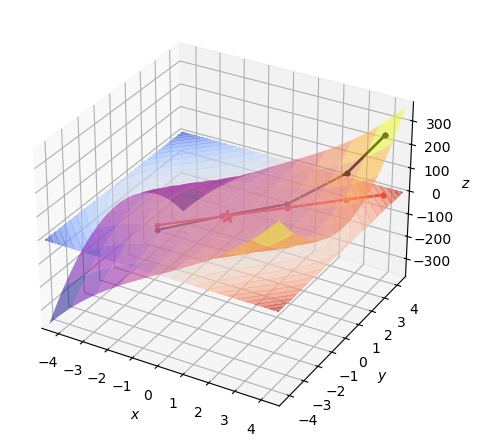

In [37]:
frames = 20
epochs = 5

'''
TODO

Make a plot to show what happens if stochastic gradient descent with momentum
is used on a function like this.

Recommended hparams:

initialization: (4., 4.)
alpha: 0.01
gamma: 0.99
'''

func = monkey
init_x, init_y = 4., 4.

hparams = {'alpha': 0.01, 'gamma': 0.99}
optim = Optimizer(init_x, init_y, 'grad_momentum', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

We observe that running the optimizer for a mere 5 epochs, Stochastic Gradient Descent with Momentum is able to move past the flat region and continue its journey downwards. Thus, it is a good optimization algorithm according to the aforementioned definition.

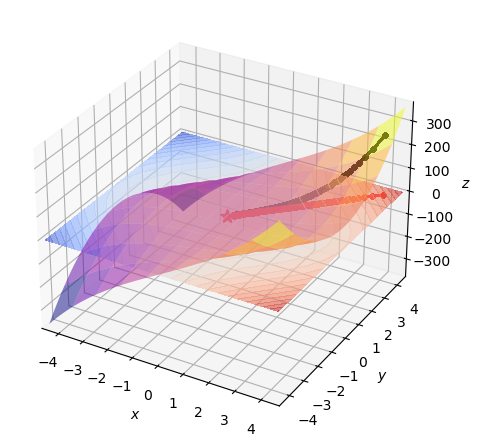

In [38]:
frames = 20
epochs = 1000

'''
TODO

Make a plot to show what happens if adagrad
is used on a function like this.

Recommended hparams:

initialization: (4., 4.)
alpha: 0.3
eps: 1e-7
'''

func = monkey
init_x, init_y = 4., 4.

hparams = {'alpha': 0.3, 'eps': 1e-7}
optim = Optimizer(init_x, init_y, 'adagrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

We observe that despite running the optimizer for 1000 epochs, Adagrad is not able to move past the flat region and continue its journey downwards. Thus, it is not a good optimization algorithm according to the aforementioned definition. It assumes the saddle point to be the global optimum, which is wrong.

# Escaping Local Minima 

Make 3 or more plots (with atleast one plot using ADAM) to show how the different functions escape the local minima on the **mult** function. We will initialize at (0.5, 0.5).

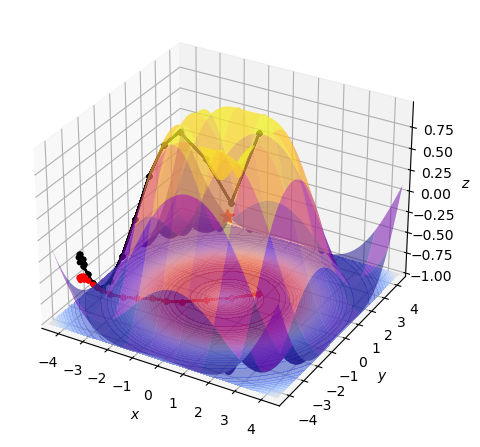

In [39]:
frames = 20
epochs = 20

'''
TODO

Make a plot to show what happens if ADAM
is used on a function like this.

Recommended hparams:

initialization: (.8, .8)
alpha: 0.7
eps: 1e-7
beta_1: 0.99
beta_2: 0.9
'''

func = mult
init_x, init_y = .8, .8

hparams = {'alpha': 0.7, 'eps': 1e-7, 'beta_1': 0.99, 'beta_2': 0.9}
optim = Optimizer(init_x, init_y, 'adam', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

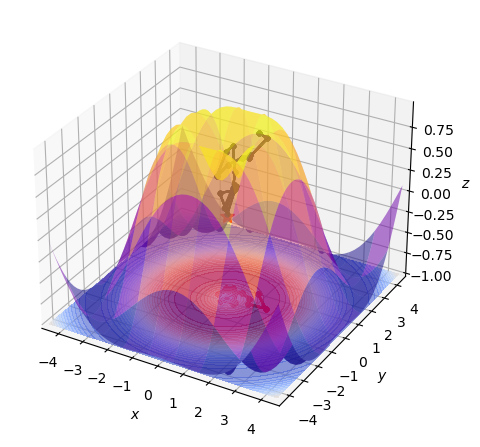

In [40]:
frames = 20
epochs = 20

'''
TODO

Make a plot to show what happens if adagrad
is used on a function like this.

Recommended hparams:

initialization: (.8, .8)
alpha: 0.7
eps: 1e-7
'''

func = mult
init_x, init_y = .8, .8

hparams = {'alpha': 0.7, 'eps': 1e-7}
optim = Optimizer(init_x, init_y, 'adagrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

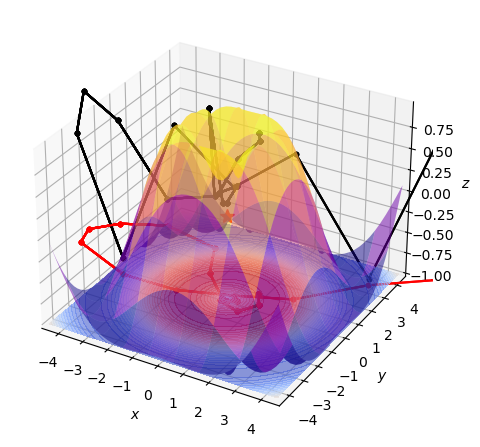

In [57]:
frames = 20
epochs = 20


'''
TODO

Make a plot to show what happens if stochastic gradient descent with momentum
is used on a function like this.

Recommended hparams:

initialization: (.8, .8)
alpha: 0.7
gamma: 0.99
'''

func = mult
init_x, init_y = .8, .8

hparams = {'alpha': 0.7, 'gamma': 0.99}
optim = Optimizer(init_x, init_y, 'grad_momentum', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

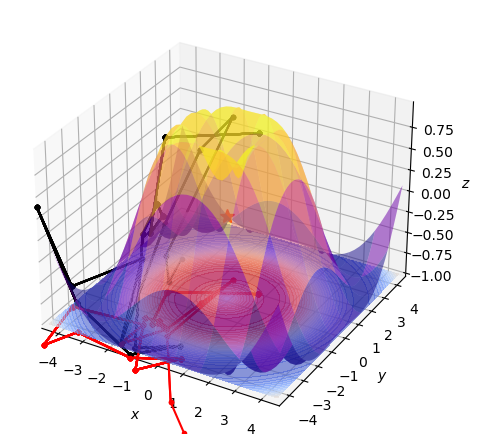

In [59]:
frames = 20
epochs = 20


'''
TODO

Make a plot to show what happens if stochastic gradient descent
is used on a function like this.

Recommended hparams:

initialization: (.8, .8)
alpha: 0.7
'''

func = mult
init_x, init_y = .8, .8

hparams = {'alpha': 0.7}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)